# Kaggle Competition 
## Fraud Detection
### by: Hunter Knighton

In [1]:
# imports
#math and data
import numpy as np
import pandas as pd
import multiprocessing
# visualizatoin
import seaborn as sns
import matplotlib.pyplot as plt
# warnings silence
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#sklearn
from sklearn.preprocessing import LabelEncoder


# Load the Data

In [2]:
train_identity = pd.read_csv('train_identity.csv')
train_transactions = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transactions = pd.read_csv('test_transaction.csv')

df = pd.merge(train_transactions, train_identity, on='TransactionID', how='left')

test = pd.merge(test_transactions,test_identity, on='TransactionID', how='left')

## Initial Exploring
 Visual Analysis to find any insights

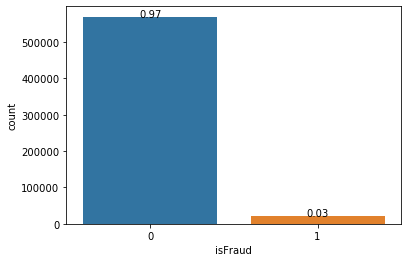

In [3]:
plt.figure(1)
ax = sns.countplot(df['isFraud'],hue=None)
total = float(len(df['ProductCD']))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")

97% non fraud compared to only 3% fraud. We know the we will need to re weight the training data for the model

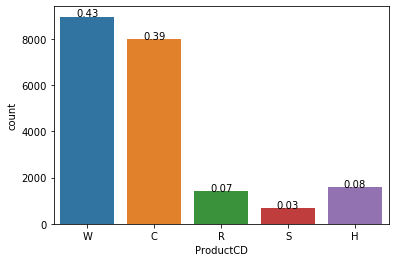

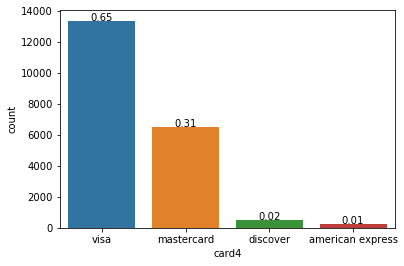

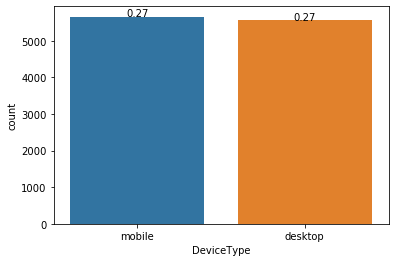

In [4]:
plt.figure(1)
ax = sns.countplot(df['ProductCD'][df['isFraud']==1],hue=None)
total = float(len(df['ProductCD'][df['isFraud']==1]))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")
plt.figure(2)
ax = sns.countplot(df['card4'][df['isFraud']==1],hue=None)
total = float(len(df['card4'][df['isFraud']==1]))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")
plt.figure(3)
ax = sns.countplot(df['DeviceType'][df['isFraud']==1],hue=None)
total = float(len(df['DeviceType'][df['isFraud']==1]))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")


    

Fraud Transaction Distribution
Non Fraud Transaction Distribution


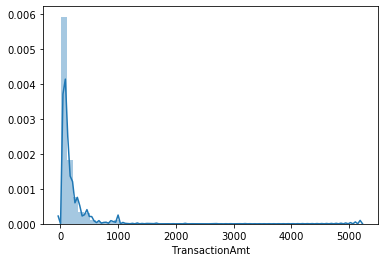

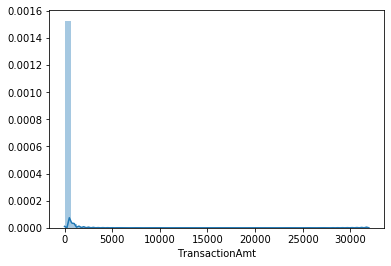

In [5]:
print("Fraud Transaction Distribution")
plt.figure(1)
sns.distplot(df['TransactionAmt'][df['isFraud']==1])
plt.figure(2)
print("Non Fraud Transaction Distribution")
sns.distplot(df['TransactionAmt'][df['isFraud']==0])

In [6]:
df = datatype_conversion(df)

NameError: name 'datatype_conversion' is not defined

Let's look at email addresses to see if we can find any useful info

In [7]:
df['P_emaildomain'].unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [8]:
# there are a few with foreign counties as top level domain we can parse these to create a new variable foreign
datasets = [df,train,test]
for dataset in datasets:
    tags = np.array(dataset['P_emaildomain'].str.split('.'))
    countries = ['jp','es','de','uk','fr']

    j = 0
    for i in tags:
        if type(i) != float:
            if i[-1] in countries:
                tags[j] = "Foreign"
            else:
                tags[j] = "Domestic"
        else:
            tags[j] = np.nan
        j +=1
    dataset['Foreign'] = tags
    print("Done")

Done
Done
Done


In [9]:
foriegn_count = df['Foreign'][df['Foreign']=='Foreign'].count()
domestic_count =  df['Foreign'][df['Foreign']!='Foreign'].count()

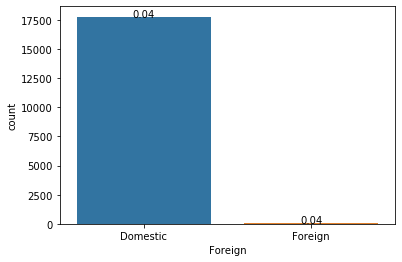

In [10]:
plt.figure(3)
ax = sns.countplot(df['Foreign'][df['isFraud']==1],hue=None)
total = float(len(df['Foreign'][df['isFraud']==1]))
i = 1
for p in ax.patches:
    height = p.get_height()
    if i == 1:
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/domestic_count),
                ha="center")
        i +=1
    else:
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/foriegn_count),
                ha="center")
        

It appears the country of origin does not add much value since about 4% of the Domestic and 4% of the foreign are fraud

A lot of interest about the decimal place on the Kaggle Kernals so i decided to incorportate inot my own model
### https://www.kaggle.com/yasagure/places-after-the-decimal-point-tell-us-a-lot

In [11]:
#The amount of decimal points is an interesting concept because it means the transaction was most likely done with a currency exchange.
def change(hoge):
   return len(str(hoge).split('.')[1])
  
  
df["TransactionAmt_decimal"] = df["TransactionAmt"].map(change)
test["TransactionAmt_decimal"] = test["TransactionAmt"].map(change)
train["TransactionAmt_decimal"] = train["TransactionAmt"].map(change)

In [12]:
df[["TransactionAmt","TransactionAmt_decimal"]].tail()

,TransactionAmt,TransactionAmt_decimal
590535,49.00,1
590536,39.50,1
590537,30.95,2
590538,117.00,1
590539,279.95,2


In [14]:
df.groupby("TransactionAmt_decimal").mean()["isFraud"]

TransactionAmt_decimal
1     0.034493
2     0.010426
3     0.118140
13    1.000000
14    0.143591
15    0.108652
16    0.009646
Name: isFraud, dtype: float64

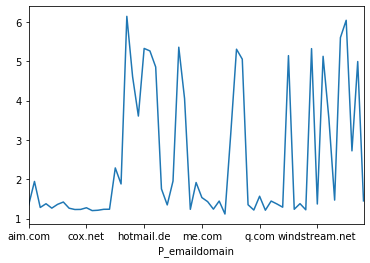

In [15]:
df.groupby("P_emaildomain").mean()["TransactionAmt_decimal"].plot()

plt.show()

In [16]:
from woe_iv import *


In [19]:
features = ['TransactionAmt','ProductCD','card1','card4','TransactionAmt_decimal','Foreign']


In [286]:
final_iv, IV = data_vars(df[features] , df['isFraud'])

In [287]:
final_iv.sort_values(by=['IV'], ascending = False)

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
12,card3,100.000,150.000000,530237,13170,0.024838,517067,0.975162,0.637371,0.907331,-0.353155,0.463656
13,card3,151.000,231.000000,60303,7493,0.124256,52810,0.875744,0.362629,0.092669,1.364345,0.463656
8,ProductCD,0.000,1.000000,101543,9582,0.094364,91961,0.905636,0.463727,0.161370,1.055598,0.454360
9,ProductCD,2.000,4.000000,488997,11081,0.022661,477916,0.977339,0.536273,0.838630,-0.447127,0.454360
23,DeviceType,2.000,2.000000,449730,9452,0.021017,440278,0.978983,0.457436,0.772584,-0.524104,0.439200
22,DeviceType,0.000,1.000000,140810,11211,0.079618,129599,0.920382,0.542564,0.227416,0.869526,0.439200
27,dist2,232.000,11623.000000,8669,937,0.108086,7732,0.891914,0.045347,0.013568,1.206636,0.039386
26,dist2,0.000,231.855423,581871,19726,0.033901,562145,0.966099,0.954653,0.986432,-0.032746,0.039386
16,P_emaildomain,33.000,60.000000,120609,3003,0.024899,117606,0.975101,0.145332,0.206371,-0.350652,0.026230
15,P_emaildomain,17.000,32.000000,157654,5771,0.036605,151883,0.963395,0.279291,0.266519,0.046811,0.026230


In [21]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Foreign,TransactionAmt_decimal
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,2
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,1
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,1
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,2
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,2


In [306]:
all_data = [df, test]
big_data = pd.concat(all_data)

In [307]:
df.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
                   ...   
id_11             float64
id_12              object
id_13             float64
id_14             float64
id_15              object
id_16              object
id_17             float64
id_18       

In [308]:
for col in list(df):
    if df[col].dtype=='O':
        print(col)
        df[col] = df[col].astype(str)
        
        test[col] = test[col].astype(str)
        
        df[col] = df[col].fillna('unseen_before_label')
        
        test[col]  = test[col].fillna('unseen_before_label')
        
        
        
        le = LabelEncoder()
        le.fit(list(big_data[col]))
        df[col] = le.transform(df[col])
       
        test[col] = le.transform(test[col])
        
        df[col] = df[col].astype('int64')
        test[col] = test[col].astype('int64')

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [309]:
types = ['int64','float64']
for col in list(df):
    if col != "isFraud":
        
        if df[col].dtype in types:
            
            

            df[col] = df[col].fillna(df[col].mean())
            
            test[col] = test[col].fillna(test[col].mean())

In [310]:
submit = test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,4,10409,111.0,150.0,4,226.0,2,...,136,26.217939,461,4,2,2,2,2,2,2740
1,3663550,18403263,49.00,4,4272,111.0,150.0,4,226.0,2,...,136,26.217939,461,4,2,2,2,2,2,2740
2,3663551,18403310,171.00,4,4476,574.0,150.0,4,226.0,2,...,136,26.217939,461,4,2,2,2,2,2,2740
3,3663552,18403310,284.95,4,10989,360.0,150.0,4,166.0,2,...,136,26.217939,461,4,2,2,2,2,2,2740
4,3663553,18403317,67.95,4,18018,452.0,150.0,2,117.0,2,...,136,26.217939,461,4,2,2,2,2,2,2740


## Simple Model

In [231]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#xgboost
from xgboost import XGBClassifier

In [199]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)


class_names = df.isFraud.unique()

In [300]:
x = df
x = x.drop('isFraud',axis=1)
y = df['isFraud']
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
x = np.array(x)
y = np.array(y)

In [302]:
clf = RandomForestClassifier(min_samples_split=2)
auc=[]
for train, test in kfold.split(x,y):
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    clf.fit(x_train,y_train)
    probs = clf.predict_proba(x_test)
    auc_score =  roc_auc_score(y_test, probs[:,1])
    auc.append(auc_score)
    print("AUC This Split: ", auc_score)
    

AUC This Split:  0.8919570791077007
AUC This Split:  0.8816030884917284
AUC This Split:  0.8841247025447672
AUC This Split:  0.8786395291452809
AUC This Split:  0.8852965665705271
AUC This Split:  0.8894741541688335
AUC This Split:  0.8883472631693458
AUC This Split:  0.8836936553743657
AUC This Split:  0.8774817505210126
AUC This Split:  0.8867318858799186


In [319]:
## XGB Boost

In [318]:
params = {'tree_method': 'hist',
 'n_estimators': 500,
 'max_delta_step': 7,
 'silent': 1,
 'colsample_bytree': 0.8999504397295506,
 'subsample': 0.7446134812140273,
 'learning_rate': 0.001,
 'max_leaves': 72,
 'objective': 'binary:logistic',
 'max_depth': 9,
 'reg_alpha': 0.7726783188295172,
 'min_child_weight': 2,
 'eval_metric': 'auc'}



In [ ]:
clf = XGBClassifier(params=params)
auc=[]
for train, test in kfold.split(x,y):
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    clf.fit(x_train,y_train)
    probs = clf.predict_proba(x_test)
    auc_score =  roc_auc_score(y_test, probs[:,1])
    auc.append(auc_score)
    print("AUC This Split: ", auc_score)

AUC This Split:  0.8963920217257564


### XGBoost

In [270]:
features = ['card1','card4','TransactionAmt','ProductCD',
            'card2','card3','P_emaildomain','card6','card5','DeviceType','dist1','dist2']
x = df[features]
y = df['isFraud']
model = XGBClassifier()
n_estimators = range(400, 600, 100)
param_grid = dict(n_estimators=n_estimators)
param_grid

{'n_estimators': range(400, 600, 100)}

In [271]:

param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x, y)

KeyboardInterrupt: 

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')


In [315]:
x_submit = np.array(submit)


In [316]:
predictions = pd.DataFrame()
predictions['TransactionID'] = submit['TransactionID']
predictions['isFraud'] = clf.predict_proba(x_submit)[:, 1]
cols = predictions.columns.tolist()
cols = cols[-1:] + cols[:-1]


submit = predictions[cols]

 
                        

submit.to_csv("submission.csv", index=False)

In [317]:
submit.head()

,isFraud,TransactionID
0,0.2,3663549
1,0.2,3663550
2,0.1,3663551
3,0.1,3663552
4,0.1,3663553
